# Protein-Protein Interaction
This notebook describes the necessary steps for the protein-protein interaction network for all the genes in our reconstruction

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import pickle
from google_sheet import GoogleSheet

# Data Fetching
import requests
import json
from pp_interactions import fetch_string_interactions, visualize_network

# Plotting
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

KEY_FILE_PATH = 'credentials.json'
SPREADSHEET_ID = '1DaAdZlvMYDqb7g31I5dw-ZCZH52Xj_W3FnQMFUzqmiQ'
gsheet_file = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)
sec_recon_sheet = 'SecRecon'
secrecon = gsheet_file.read_google_sheet(sec_recon_sheet)

In [3]:
# Load Reconstruction

gene_dict_path = 'gene_dict.pkl'
with open(gene_dict_path, 'rb') as file:
    gene_dict = pickle.load(file)

# Create gene_list
gene_list = list(gene_dict.keys())

### 1.STRINGS

In [4]:
G_string = fetch_string_interactions(gene_list)

# Save the network generated
nx.write_graphml(G_string, 'Network/string_interactions_sec_recon.graphml')

Fetching Interactions:  33%|█████▌           | 368/1130 [02:47<05:22,  2.36it/s]

No interaction found for HSP90AA4P


Fetching Interactions:  33%|█████▌           | 369/1130 [02:47<04:39,  2.72it/s]

No interaction found for HSP90AA5P


Fetching Interactions:  33%|█████▌           | 371/1130 [02:47<03:51,  3.27it/s]

No interaction found for HSP90AB2P


Fetching Interactions:  33%|█████▌           | 372/1130 [02:47<03:35,  3.51it/s]

No interaction found for HSP90AB3P


Fetching Interactions:  33%|█████▌           | 373/1130 [02:48<03:53,  3.25it/s]

No interaction found for HSP90AB4P


Fetching Interactions: 100%|████████████████| 1130/1130 [08:39<00:00,  2.18it/s]


In [5]:
len(G_string)

1058

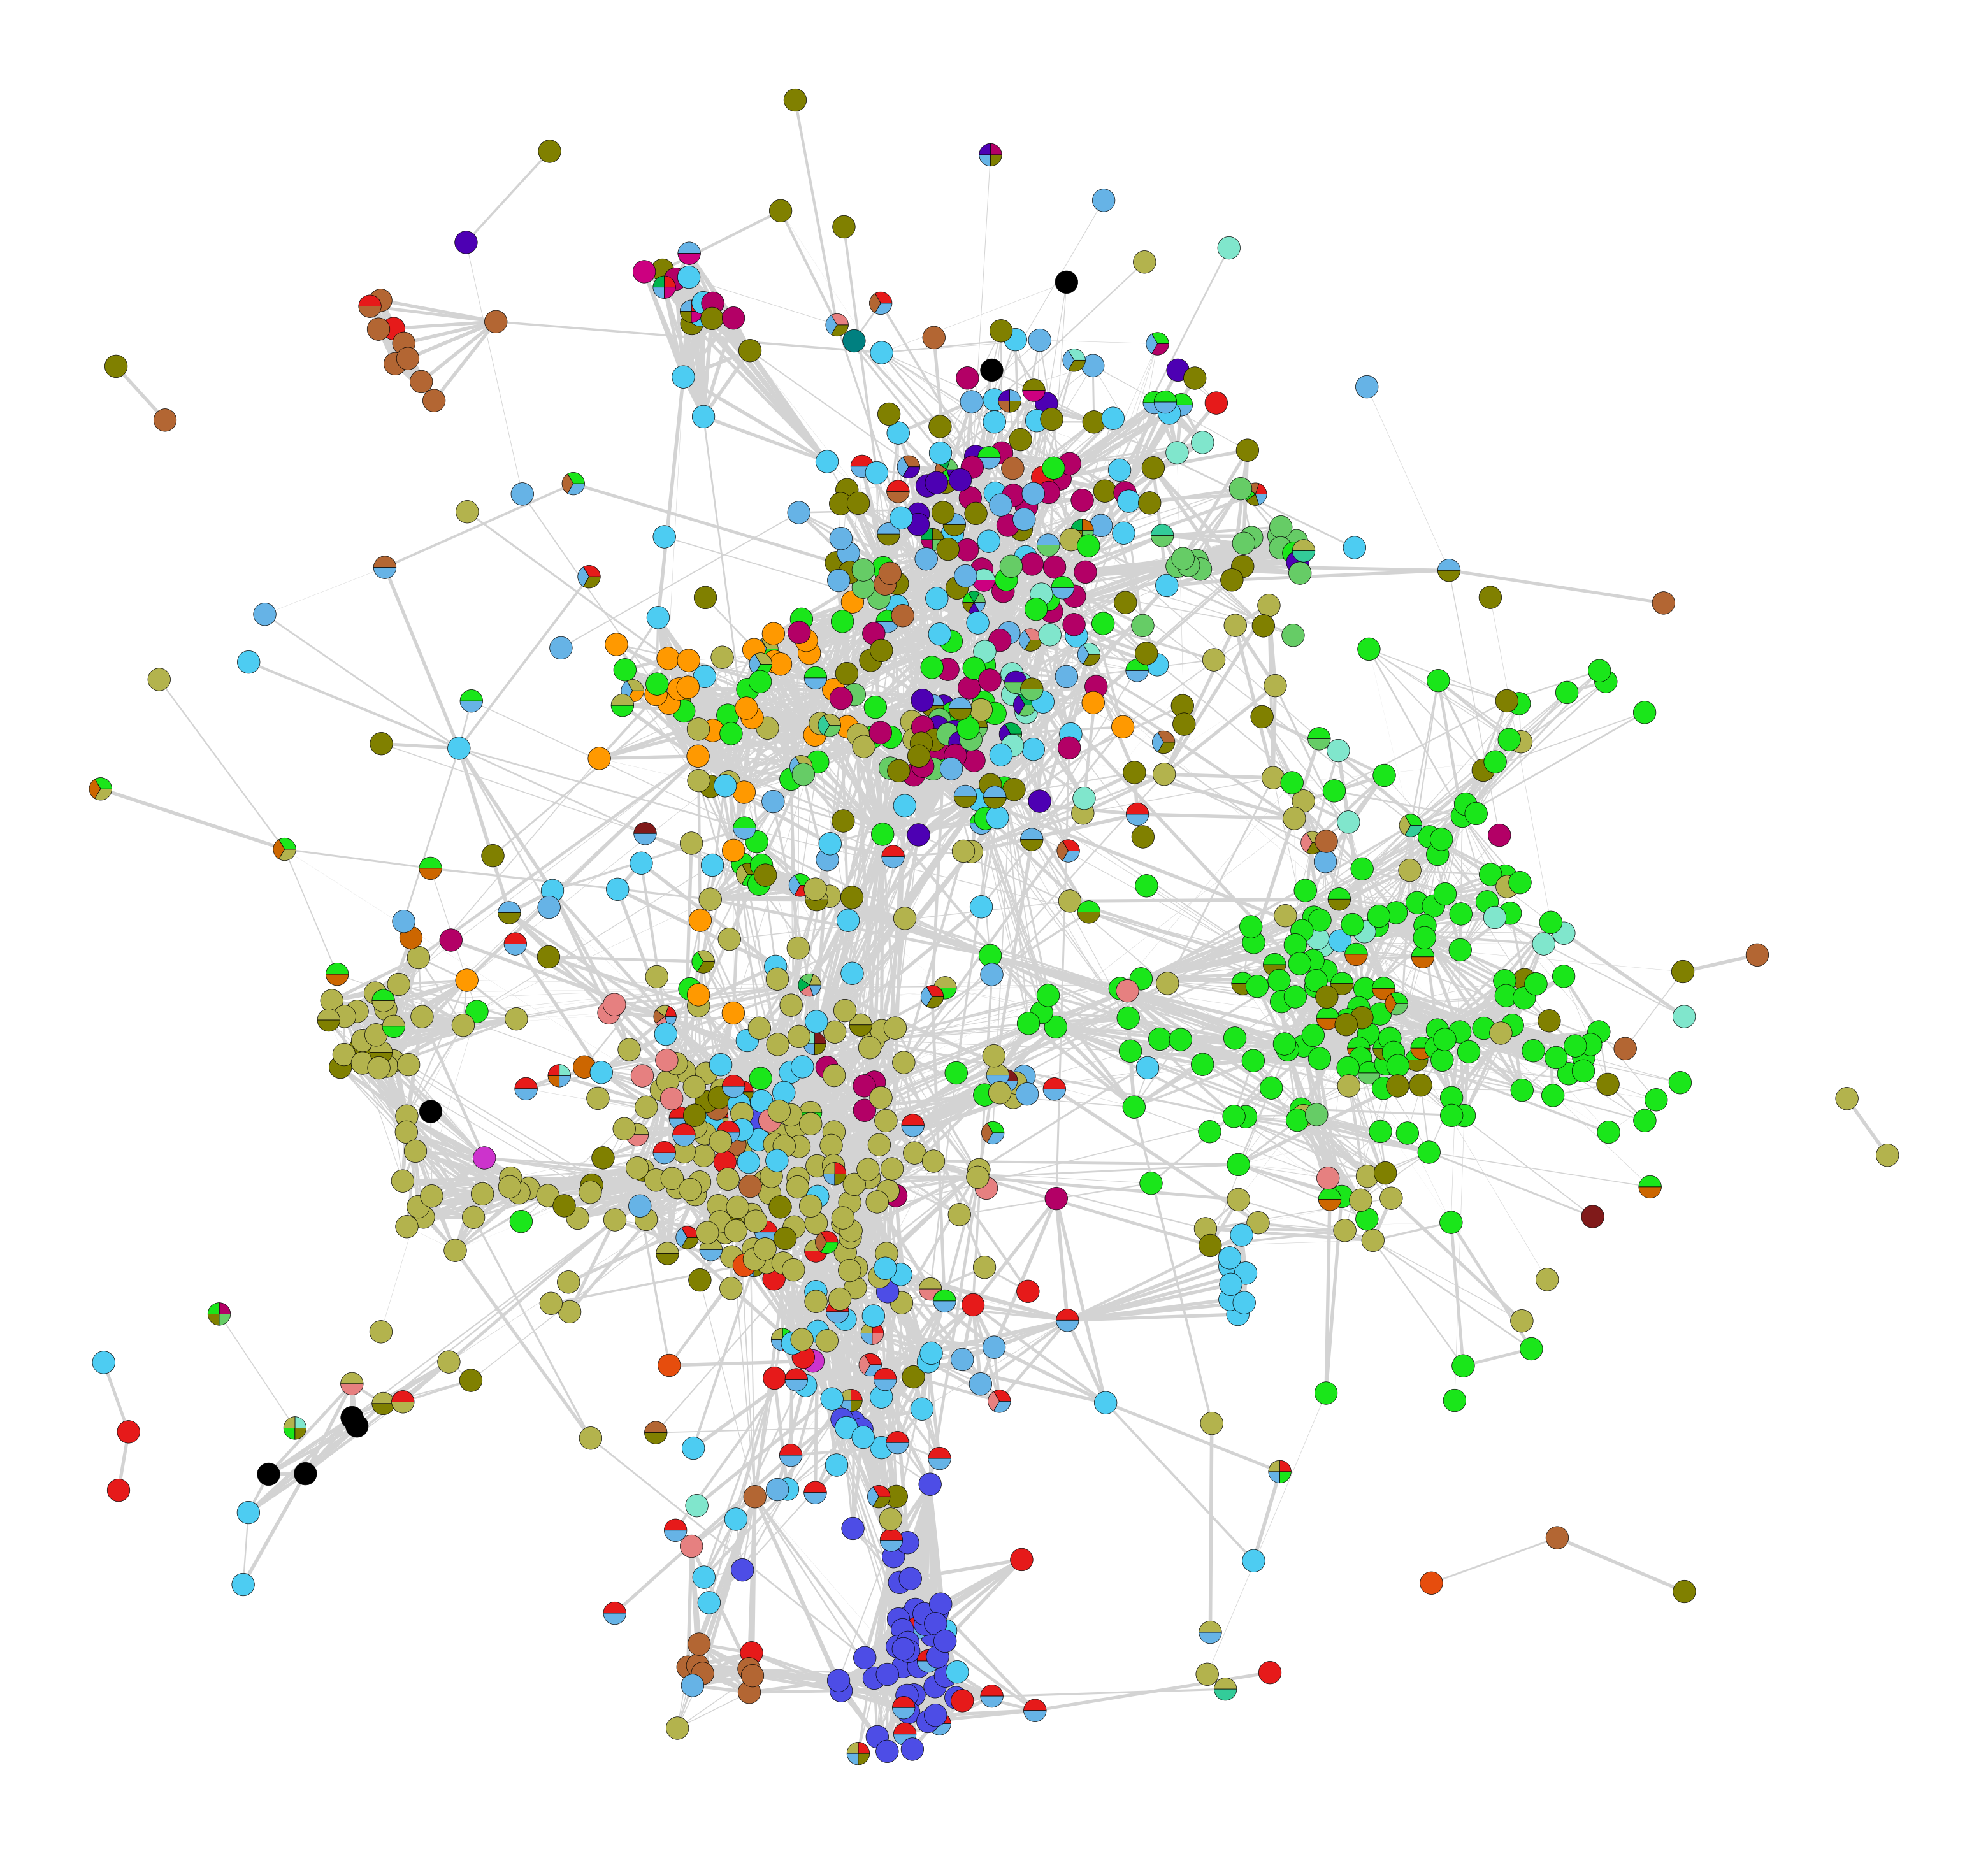

In [8]:
#G_string = nx.read_graphml('Network/string_interactions_sec_recon.graphml')
filename = f"Network/STRING_interactions_localizationcolor.png"
visualize_network(G=G_string, node_size=0.012, filename=filename, color_by='localization', legends=False) 

### 2.PrePPI
For this part, create a python dict with the uniprot IDs from secrecon as keys and the gene symbols as values, then mapped those gene symbols to the preppi database.

https://www.sciencedirect.com/science/article/pii/S0022283623001080?via%3Dihub
https://honiglab.c2b2.columbia.edu/PrePPI/

In [9]:
# Initialize an empty dictionary to store the UniProt ID as key and the Gene Symbol as value
uniprot_gene_dict = {}

# Iterate through each row in the DataFrame
for index, row in secrecon.iterrows():
    # Check if the UniProt field is not None or NaN
    if pd.notna(row['HUMAN UNIPROT']):
        # Split the UniProt IDs by comma
        uniprot_ids = row['HUMAN UNIPROT'].split(',')
        # Map each UniProt ID to the gene symbol
        for uniprot_id in uniprot_ids:
            uniprot_gene_dict[uniprot_id.strip()] = row['GENE SYMBOL']

In [10]:
preppi_file_path = 'Input/preppi_interactome/preppi.human_af.interactome.txt'
preppi_df = pd.read_csv(preppi_file_path, sep='\t')

In [11]:
# Map 'prot1' and 'prot2' using the dictionary
preppi_df['prot1_gene_symbol'] = preppi_df['prot1'].map(uniprot_gene_dict)
preppi_df['prot2_gene_symbol'] = preppi_df['prot2'].map(uniprot_gene_dict)

In [12]:
filtered_df = preppi_df.dropna(subset=['prot1_gene_symbol', 'prot2_gene_symbol'])

In [13]:
# Initialize an empty graph
G_preppi = nx.Graph()

seen_interactions = set()

for i,row in filtered_df.iterrows():
    protein1 = row['prot1_gene_symbol']
    protein2 = row['prot2_gene_symbol']
    interaction_tuple = (protein1, protein2)
    # Remove proteins interacting with themselves
    if protein1 != protein2:
        # Check if interaction is already seen, considering both directions
        if interaction_tuple not in seen_interactions and (protein2, protein1) not in seen_interactions:
            score = row['total_score']
            # Add nodes and edges to the graph if interaction is new
            G_preppi.add_node(protein1)
            G_preppi.add_node(protein2)
            G_preppi.add_edge(protein1, protein2, weight=score)
            # Add to seen interactions in both orders
            seen_interactions.add(interaction_tuple)
            seen_interactions.add((protein2, protein1))

In [14]:
len(G_preppi)

1035

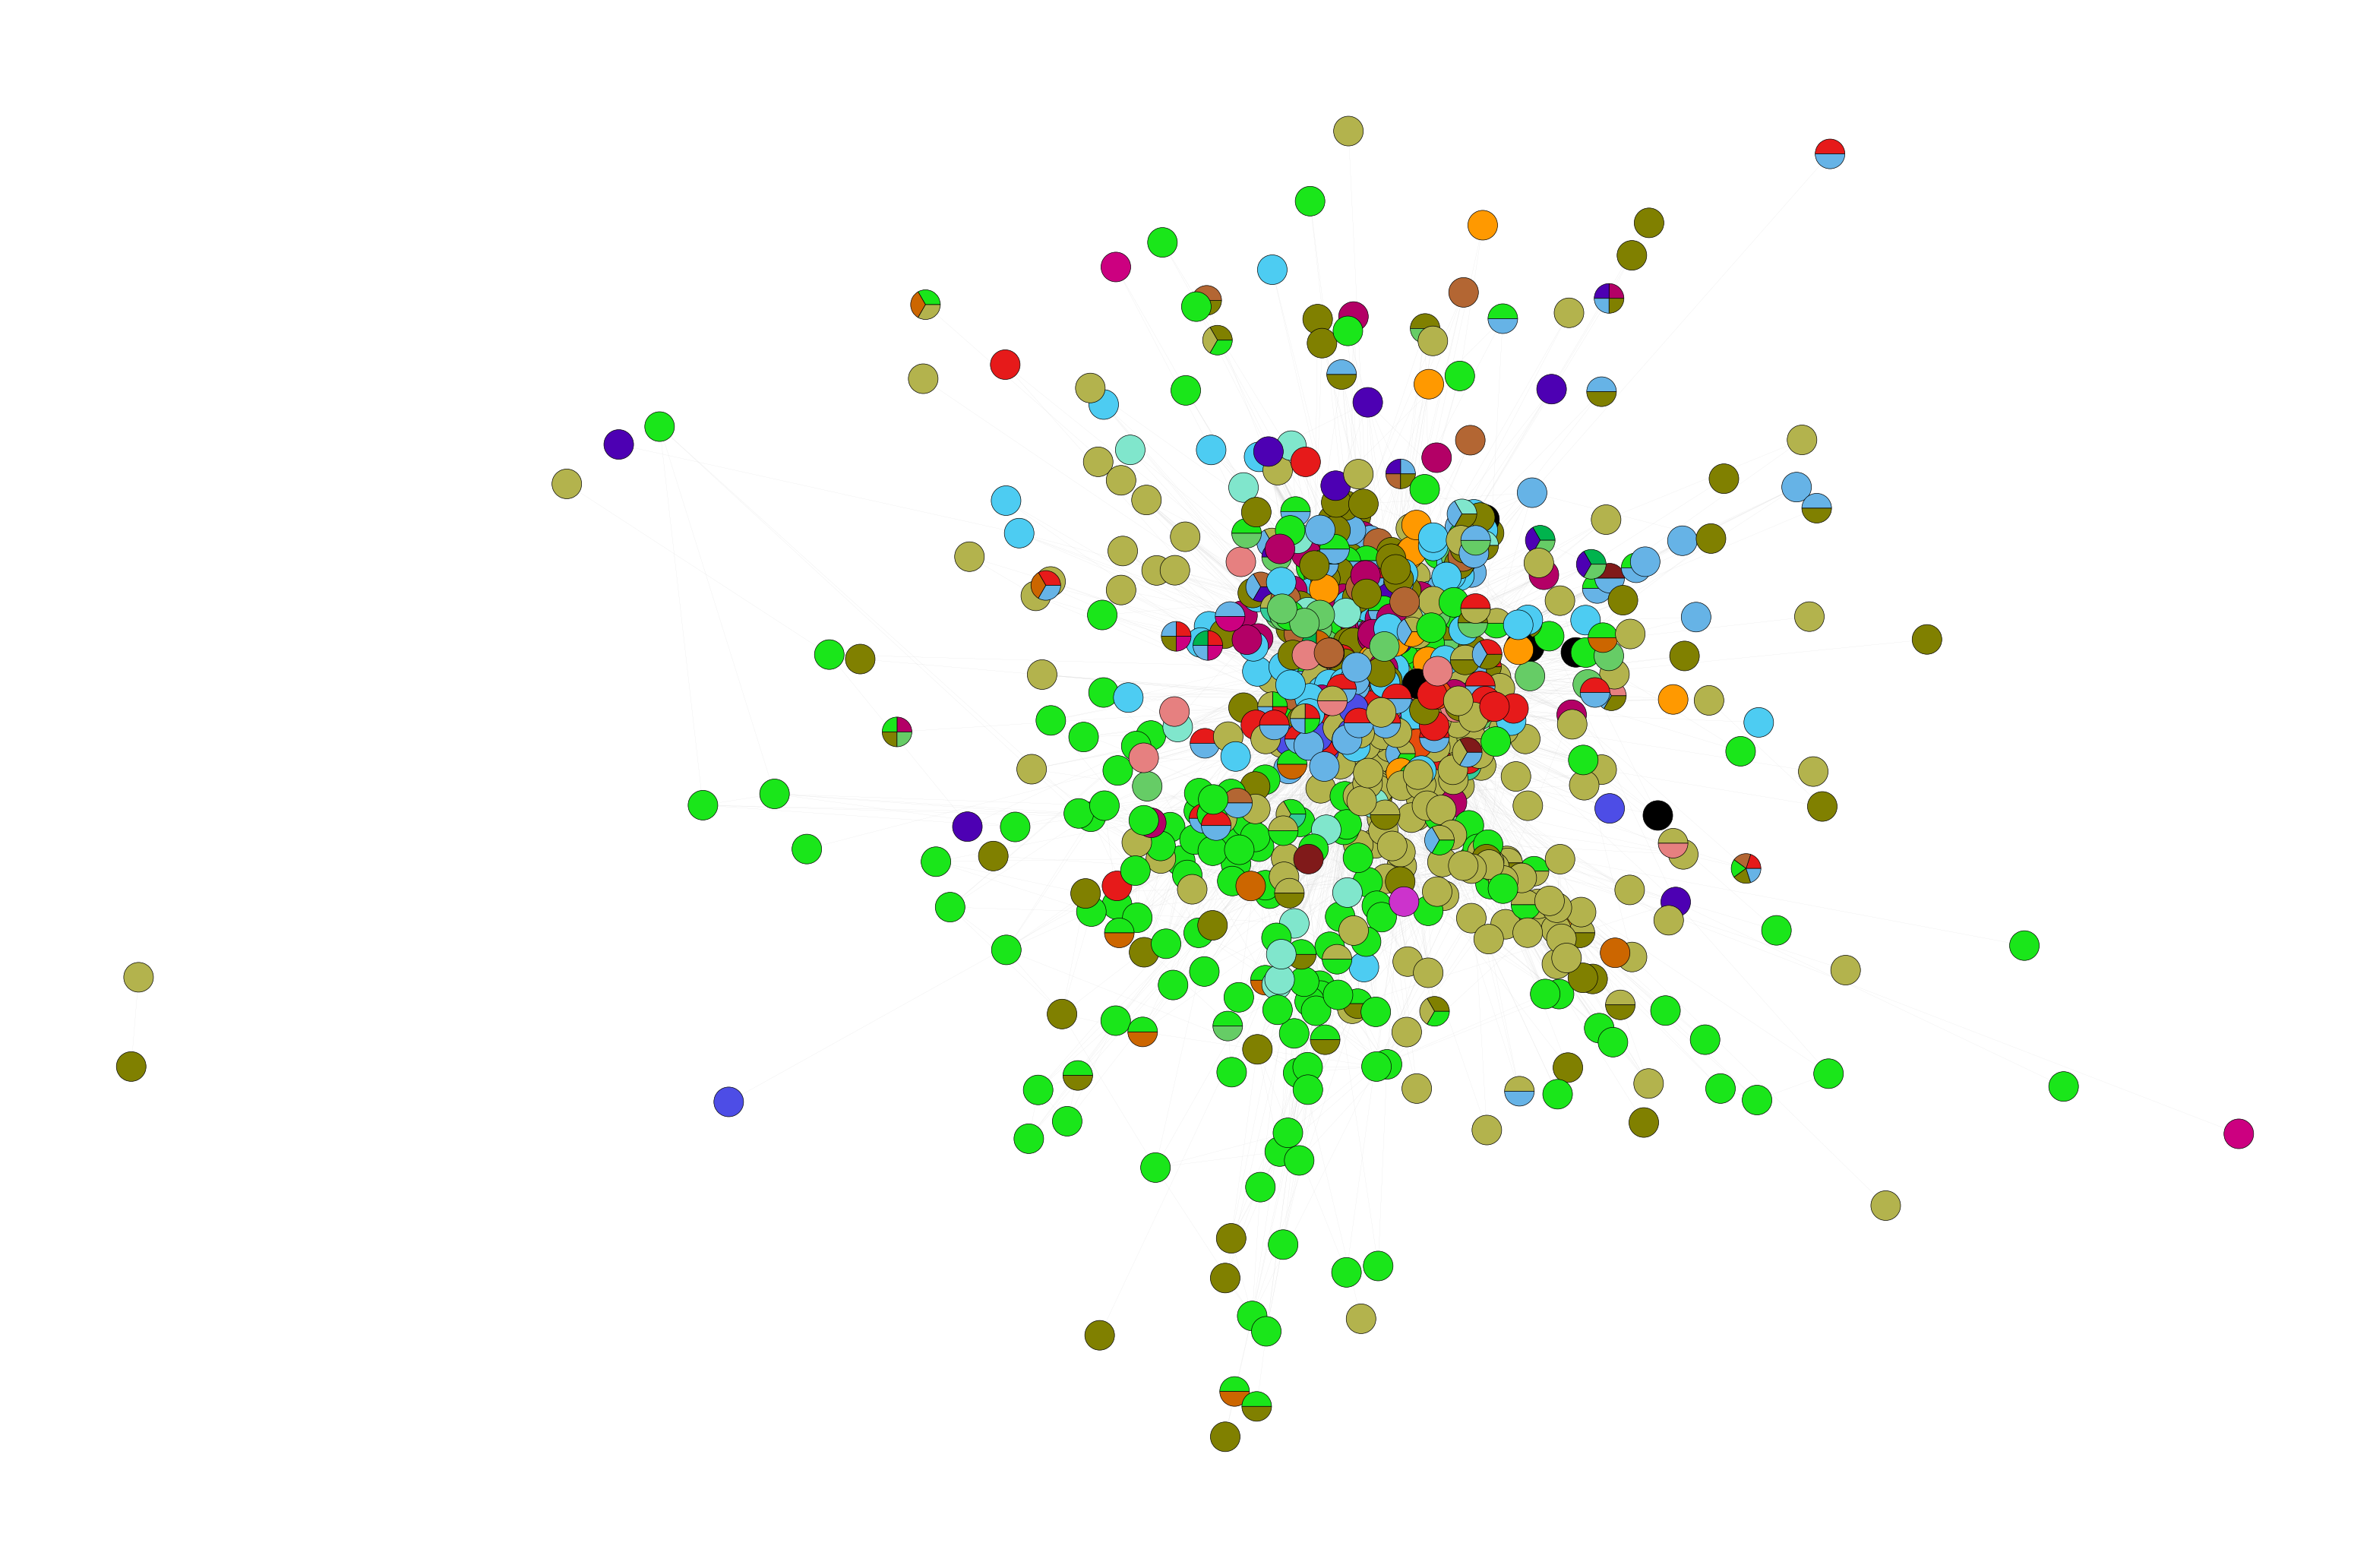

In [16]:
filename = f"Network/PrePPI_interactions_localizationcolor.png"
visualize_network(G=G_preppi, node_size=0.012, filename=filename, dist=2.5, itrs=150, color_by='localization', legends=False) 